# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, our goal is to write a software pipeline to detect vehicles in a video (project_video.mp4).

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a  Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## First, we will load the data. We are using data provided by udacity.

In [3]:
import glob 
import numpy as np
import skimage
from skimage import data, color, exposure

cars_in = glob.glob("./vehicles/*/*.png")
non_cars_in = glob.glob("./non-vehicles/*/*.png")

# Read cars and notcars
cars = []
notcars= []
for name in cars_in:    
    cars.append(skimage.io.imread(name))
print('number of cars: ', len(cars))

for name in non_cars_in:    
    notcars.append(skimage.io.imread(name))
print('number of non-cars: ', len(notcars))
    
print()
print("Image Shape: {}".format(cars[0].shape))

filepaths = np.hstack((cars_in[slice(None)], non_cars_in[slice(None)]))

number of cars:  8792
number of non-cars:  8968

Image Shape: (64, 64, 3)


## Let us perform a Histogram of Oriented Gradients (HOG) feature extraction on an couple of images to visulaize the cars and non cars. Just experimenting before the actual feature extraction.

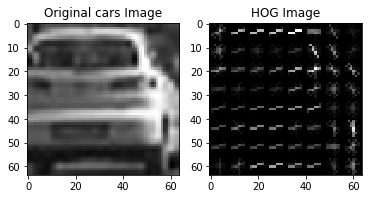

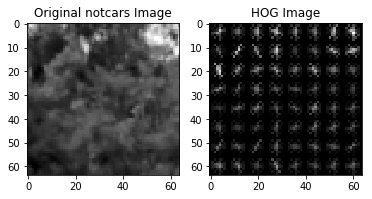

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
# Visualizations will be shown in the notebook.
%matplotlib inline

# Define a function to return HOG features and visualization
def img_get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Feature extraction parameters 
orient = 9
pix_per_cell = 8
cell_per_block = 2

#Try it on a cars example images
feature_image = cars[5]
gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)

hog_features, hog_image = img_get_hog_features(gray, orient, 
                          pix_per_cell, cell_per_block, vis=True,
                          feature_vec=True)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray, cmap='gray')
ax1.set_title('Original cars Image')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Image')

#Try it on a notcars example images
feature_image = notcars[5]
gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)

hog_features, hog_image = img_get_hog_features(gray, orient, 
                          pix_per_cell, cell_per_block, vis=True,
                          feature_vec=True)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray, cmap='gray')
ax1.set_title('Original notcars Image')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Image')

## Next let us implement a sliding window. Again, a little exploration before vehicle detection sliding window implementation.

(720, 1280, 3)


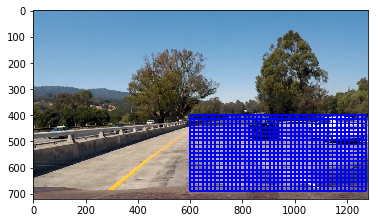

In [5]:
image = mpimg.imread('test_images/test1.jpg')
print(image.shape)

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Let us perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.

In this code in the cell below, we extract HOG, color histogram and spatial features and train the SVM classifier. 

We use the following parameters for each color channel for the HOG feature estraction: orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)). For a 64X64 image it generates 5292 features (7X7X2X2X9X3 = 5292)

We use 32 bins for the color histogram feature extraction for each color channel and concatenate them together. This results in 96 features (32+32+32 = 96).

We resize the image to 32X32 for spatial feature extraction which yields 1024 features for each color channel. This yields 3072 features (32X32X3 = 3072).

The total number of features for HOG, color histogram and spatial is 8460 features per image (5292+96+3072= 8460). We randomly split the total number of features for training and testing. 

StandardScaler was used to scale the features down evenly with a zero mean.

We use these features to train a Linear SVM classifier. After experimenting many times and trying several color spaces including RGB, HSV & HSL, we chose the YCrCb colorspace. The test accuracy of the SVM was 99%.

In [6]:
import cv2
import time
import glob
import numpy as np
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


def read_rgb_image(filepath, filetype="jpg"):
    
    image = mpimg.imread(filepath)

    if filetype == "png":
        image = (image * 255).astype(np.uint8)

    return image

def get_hog_features(image, 
                    channel,
                    vis=False,
                    orientations=9,
                    pixels_per_cell=(8,8),
                    cells_per_block=(2,2)):
    if vis == True:
        features, hog_image = hog(image[:, :, channel], visualise=vis, feature_vector=True, 
                                  orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(image[:, :, channel], visualise=vis, feature_vector=True, 
                                  orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block)
        return features
    
def get_hist_features(image, bins=32):
    histogram_0 = np.histogram(image[:, :, 0], bins=bins)
    histogram_1 = np.histogram(image[:, :, 1], bins=bins)
    histogram_2 = np.histogram(image[:, :, 2], bins=bins)
    
    features = np.concatenate((
        histogram_0[0],
        histogram_1[0],
        histogram_2[0],))
    
    return features

def get_spatial_features(image, size=(32,32)):
    features = cv2.resize(image, size).ravel()
    
    return features

def extract_image_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb) #convert image to YCrCb
    
    hog_features_0 = get_hog_features(image, 0)
    hog_features_1 = get_hog_features(image, 1)
    hog_features_2 = get_hog_features(image, 2)
    hog_features = np.ravel([hog_features_0, hog_features_1, hog_features_2])
    hist_features = get_hist_features(image)
    spatial_features = get_spatial_features(image)
    #print('hog: ', len(hog_features))
    #print('hist: ', len(hist_features))
    #print('spatial: ', len(spatial_features))
    features = np.concatenate([hog_features, hist_features, spatial_features])
    #print('featuress: ', len(features))
    
    return features

def scale_features(features):
    features = np.array(features).astype(np.float64)
    scaler = StandardScaler()
    scaler.fit(features)
    features = scaler.transform(features)
    return features, scaler

cars_in = glob.glob("./vehicles/*/*.png")
non_cars_in = glob.glob("./non-vehicles/*/*.png")
filepaths = np.hstack((cars_in[slice(None)], non_cars_in[slice(None)]))

# extract features
print('extract features')
features=[]
for filepath in filepaths:
    image = read_rgb_image(filepath, filetype="png")
    features.append(extract_image_features(image))
print(' number of images: ', len(features))
print(' feature shape: ', features[0].shape)

# scale features
print('scale features')
features, scaler = scale_features(features)

# create labels
print('create labels')
num_cars = len(cars_in[slice(None)])
num_non_cars = len(non_cars_in[slice(None)])
labels = np.hstack((np.ones(num_cars), np.zeros(num_non_cars)))
print(' labels: cars noncars total ', num_cars, num_non_cars, len(labels))

# split features
print('split features')
rand = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=rand)

# ***shuffle data 
X_train, y_train = shuffle(X_train, y_train) 

# define a linear support vector calssifier (svc)
print('define svc')
svc = LinearSVC()

# fit data to svc
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

extract features
 number of images:  17760
 feature shape:  (8460,)
scale features
create labels
 labels: cars noncars total  8792 8968 17760
split features
define svc
17.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9958
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00269 Seconds to predict 10 labels with SVC


## Let us find some cars!

In the next code cell we perform the sliding window search and vehicle detection for a test image. Earlier we had implemented the sliding window during experimentation. Now we use it for vehicle detection. We use two size windows 128X128 and 64X64. We resize the 128X128 sliding window to 64X64 before we extract features. Also we restrict our search to the lower right half of the image to optimize performance and reduce false positives. 

We iterate through each sliding window to detect vehicles, calculating the features for each sliding window then running that through the classifier. If a car is predicted, the bounding boxes of the window are saved. Heat was applied to each sliding window that detected a car. Overlapping bounding boxes indicated an actual car. It reduces the number of false positives. An image at each stage of the pipeline is shown below.

finding cars...


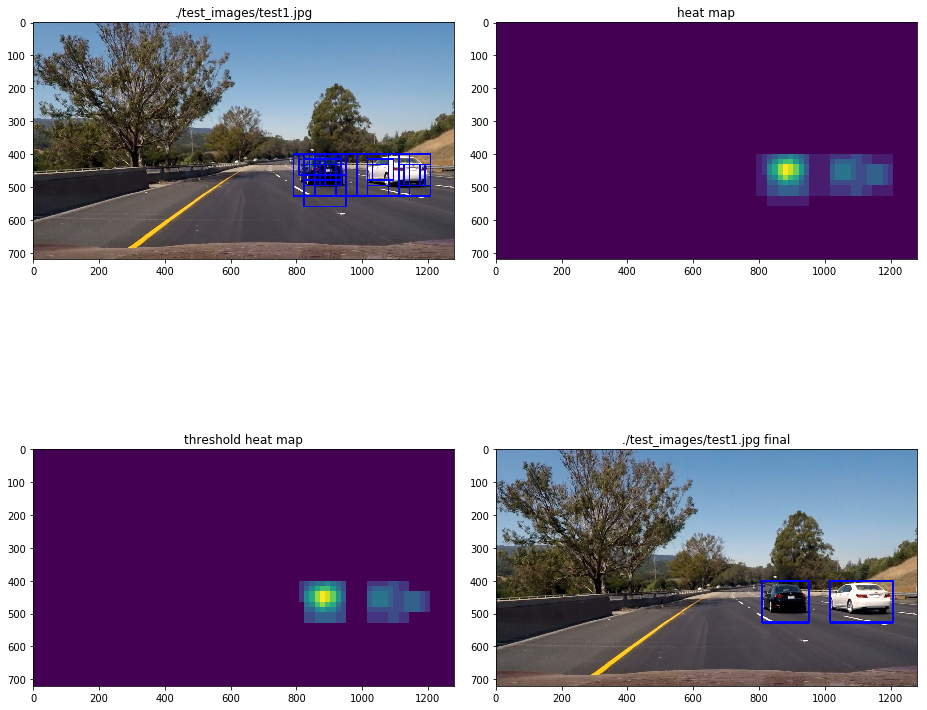

In [7]:
from scipy.ndimage.measurements import label

def draw_bounding_boxes(image, bounding_boxes, color=(0, 0, 255)):
    for ((start_x, start_y), (end_x, end_y)) in bounding_boxes:
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color, 4)
    return image

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars(model, image):    
    windows128 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows64 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows = windows128+windows64
    
    #print(len(windows))
    #print(windows[0])
   
    features = []
    bounding_boxes = [] 
    for ((start_x, start_y), (end_x, end_y)) in windows:
        slice_x = slice(start_x, end_x)
        slice_y = slice(start_y, end_y)
        image_slice = image[slice_y, slice_x]
        image_slice = cv2.resize(image_slice, (64,64))
        
        #plt.imshow(image_slice)
        features = (extract_image_features(image_slice))
        features = features.reshape((1,-1))
        features = scaler.transform(features)
        
        prediction = model.predict(features)
                
        if (prediction == 1):
            bounding_boxes.append(((start_x, start_y), (end_x, end_y)))
    
    
    return image, bounding_boxes    
    
#f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(1, 2, figsize=(13, 12))
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 12))
f.tight_layout()

print('finding cars...')

# add bounding boxes to found cars
img = read_rgb_image("./test_images/test6.jpg")
image, bounding_boxes = find_cars(svc, img)
image = draw_bounding_boxes(image, bounding_boxes)
ax1.set_title("./test_images/test1.jpg")
ax1.imshow(image)

# add heat
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, bounding_boxes)
ax2.set_title("heat map")
ax2.imshow(heatmap)

# Apply threshold to help remove false positives
heatmap = apply_threshold(heatmap,1)
ax3.set_title("threshold heat map")
ax3.imshow(heatmap)

# add final boxes to original image from heatmap using label function
orig_image = read_rgb_image("./test_images/test6.jpg")
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(orig_image), labels)
ax4.set_title("./test_images/test1.jpg final")
ax4.imshow(draw_img)

plt.show()

## Let us apply the pipleine to the test_video.mp4 before applying it to the project_video.mp4.

This allowed me to experiment with accumulating heatmaps from frame to frame to reduce the jitter. The resulting video is saved as P5_test_video.mp4.


In [8]:
heatmaps = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

def process_image(img):
    #video pipeline
    image, bounding_boxes = find_cars(svc, img)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, bounding_boxes)
    global heatmap_sum
    heatmap_sum = heatmap_sum + heatmap
    heatmaps.append(heatmap)
    # subtract off old heat map to keep running sum of last n heatmaps
    if len(heatmaps)>15:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum,0.0,1000000.0)
    heatmap = apply_threshold(heatmap_sum,1)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)
    return result    
    
    
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_video_output = 'P5_test_video.mp4'
clip1 = VideoFileClip('test_video.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video P5_test_video.mp4
[MoviePy] Writing video P5_test_video.mp4


 97%|█████████▋| 38/39 [01:32<00:02,  2.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_test_video.mp4 

CPU times: user 1min 32s, sys: 160 ms, total: 1min 32s
Wall time: 1min 34s


## Finally we apply the pipleine to the project_video.mp4 and produce  P5_project_video.mp4.

In [9]:
heatmaps = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

def process_image(img):
    #video pipeline
    image, bounding_boxes = find_cars(svc, img)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, bounding_boxes)
    global heatmap_sum
    heatmap_sum = heatmap_sum + heatmap
    heatmaps.append(heatmap)
    
    # subtract off old heat map to keep running sum of last n heatmaps
    if len(heatmaps)>15:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum,0.0,1000000.0)
    
    heatmap = apply_threshold(heatmap_sum,1)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_video_output = ('P5_project_video.mp4')
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video P5_project_video.mp4
[MoviePy] Writing video P5_project_video.mp4


100%|█████████▉| 1260/1261 [51:19<00:02,  2.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_project_video.mp4 

CPU times: user 51min 12s, sys: 2.13 s, total: 51min 14s
Wall time: 51min 21s


You may view the video here: https://www.youtube.com/watch?v=Vin_ROZP7wc

## Discussion
Here are the salient points: 
1. This code should be optimized. Just ran out of time! 
2. Many approaches (Decision Tree, for example) were not even attempted. 
3. Challenge problems were not even attempted.
4. Need to develop better debugging techniques (to view intermediate results, for example). 
5. As usual, this project was a humbling experience. I wish I could work on it full time!!